In [79]:
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parse_results import *
from utils.utils import *
from db_utils.utils import *
from db_utils.query_storage import *
import networkx as nx
from cardinality_estimation.algs import *
import numpy as np
from cardinality_estimation.losses import *
#from cardinality_estimation.join_loss import JoinLoss, get_join_cost_sql, get_leading_hint
from cardinality_estimation.join_loss import *

from sql_rep.utils import nodes_to_sql, path_to_join_order
#from cvxopt import matrix, solvers
#import cvxopt
import cvxpy as cp
import time
import copy
# FIXME: separate jupyter utils files especially for plotting utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
def qerr(true, est):
    qerrs = []
    for k,y in true.items():
        yhat = est[k]
        qerrs.append(max( y / yhat, yhat / y))
    return sum(qerrs) / len(qerrs)

def eval_alg(sql, y, yhat, join_graph):
    print("qerr: ", qerr(y, yhat))
    est_costs, opt_costs, est_plans, opt_plans, est_sqls, opt_sqls = \
                env.compute_join_order_loss([sql], [join_graph],
                        [y], [yhat], None, True, num_processes=1, postgres=True, pool=None)
    print("jerr: {}".format(est_costs[0]-opt_costs[0]))
    plot_explain_join_order(est_plans[0], y, yhat, None, "Plan based on Estimates")
    plt.show()

    plot_explain_join_order(opt_plans[0], y, y, None, "Plan based on true values")
    plt.show()
    print(opt_costs)
    return opt_costs[0]

def plot_flow_path(edges, subsetg, solx, final_node, source_node):
    source_node = tuple("s")
    cur_node = final_node
    edge_dict = {}
    edge_widths = {}
    for i, e in enumerate(edges):
        edge_dict[e] = i
        edge_widths[e] = solx[i]

    all_edges = []
    best_path_nodes = []
    while True:
        out_edges = subsetg.out_edges(cur_node)
        min_cost_edge = None
        min_cost = -100000000000
    
        for edge in out_edges:
            idx = edge_dict[edge]
            wt = solx[idx]
            if wt > min_cost:
                min_cost_edge = edge
                min_cost = wt
        all_edges.append(min_cost_edge)
        best_path_nodes.append(cur_node)
        cur_node = min_cost_edge[1]
        all_edges.append(min_cost_edge)
        if cur_node == source_node:
            best_path_nodes.append(cur_node) 
            break

    print("going to draw flow path")
    draw_graph(subsetg, highlight_nodes=best_path_nodes, edge_widths=edge_widths)
    

In [81]:
QUERY_DIR = "./our_dataset/queries/"
#query = "4a/4a10.pkl"
query = "1a/1a1010.pkl"

COST_MODEL = "cm1"
COST_KEY = COST_MODEL + "cost"
#QUERY_DIR = "./debug_sqls/"
#query = "1.pkl"
#query = "2.pkl"

qfn = QUERY_DIR + query
postgres = Postgres()
true_alg = TrueCardinalities()

USER = "ubuntu"
PWD = ""
HOST = "localhost"
PORT = 5432
DB_NAME = "imdb"


# for join loss computations
env = JoinLoss(COST_MODEL, "ubuntu", "", "localhost", 5432, "imdb")

In [82]:
qrep = load_sql_rep(qfn)
join_graph = qrep["join_graph"]
subset_graph = qrep["subset_graph"]
sql = qrep["sql"]
print(sql)

SELECT COUNT(*) FROM title as t,
kind_type as kt,
movie_info as mi1,
info_type as it1,
movie_info as mi2,
info_type as it2,
cast_info as ci,
role_type as rt,
name as n
WHERE
t.id = ci.movie_id
AND t.id = mi1.movie_id
AND t.id = mi2.movie_id
AND mi1.movie_id = mi2.movie_id
AND mi1.info_type_id = it1.id
AND mi2.info_type_id = it2.id
AND it1.id = '3'
AND it2.id = '7'
AND t.kind_id = kt.id
AND ci.person_id = n.id
AND ci.role_id = rt.id
AND mi1.info IN ('Adventure','Animation','Crime','Documentary','History','Musical','Romance','Sci-Fi','Short','Thriller')
AND mi2.info IN ('OFM:16 mm','OFM:35 mm','PCS:Spherical','PFM:16 mm','PFM:35 mm','RAT:1.37 : 1','RAT:2.35 : 1')
AND kt.kind IN ('tv series','video game','video movie')
AND rt.role IN ('production designer')
AND n.gender IN ('f')
AND t.production_year <= 1970
AND 1950 < t.production_year



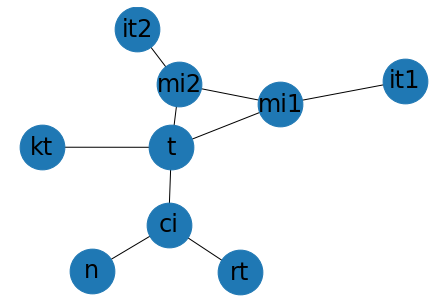

In [83]:
nx.draw(join_graph, pos=nx.spring_layout(join_graph), with_labels=True, node_size=2000, font_size=24)

qerr:  432.7536252399954
compute postgres join error took:  0.02938103675842285
jerr: 259601.09999999998


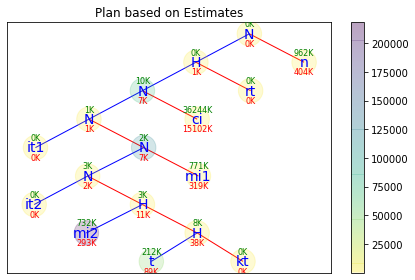

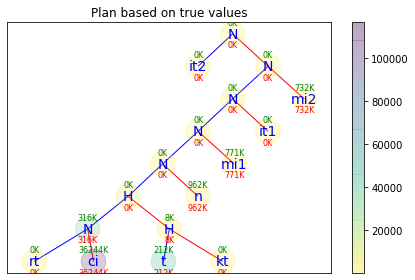

[199621.07]


In [84]:
y = true_alg.test([qrep])
y_pg = postgres.test([qrep])

random_alg = Random()
true_random = TrueRandom()
y_rand = random_alg.test([qrep])
y_true_rand = true_random.test([qrep])
sql = fix_query(sql)

opt_cost = eval_alg(sql, y[0], y_pg[0], join_graph)

In [25]:
def dont_change_subset(k,v):
    ret = None
    #if "t" in k and "mi1" in k:
    if "ci" in k:
        ret = v
    else:
        ret = v + random.randint(-1000000,1000000)
    if ret <= 0:
        ret = 1
    return ret

def change_subset(k,v):
    ret = None
    # if "n" in k or "ci" in k:
    if "kt" in k and "t" in k and len(k) == 2:
       # ret = v -= random.randint(-100000,100000)
        ret = 10000
    #if "n" in k :
       # ret = random.randint(-100000,100000)
    #elif "rt" in k and "ci" in k and len(k) == 2:
        #ret = v * 1
    elif "rt" in k and "ci" in k and "t" in k and len(k) == 3:
        ret = 108 * 1000
    elif "kt" in k and "ci" in k and "t" in k and len(k) == 3:
        ret = 108 * 1000
    elif "kt" in k and "ci" in k and "t" in k and "rt" in k and len(k) == 4:
        ret = 108 * 1000
    else:
        ret = v
        #ret = v + random.randint(-100,100)
    if ret <= 0:
        ret = 1
    return ret

def small_change(k,v):
    v += random.randint(-10000,10000)
    if v <= 0:
        v = 1
    return v
        
test_ests = {}
num_changed = 0
#for k,v in y[0].items():
for k,v in y_pg[0].items():
    test_ests[k] = change_subset(k,v)
    if test_ests[k] != v:
        num_changed += 1
        
print("total: {}, num changed: {}".format(len(y[0]), num_changed))
eval_alg(sql, y[0], test_ests, join_graph)

total: 37, num changed: 0
qerr:  4.778827990793778
compute postgres join error took:  0.012585878372192383
jerr: 0.0


4749973.11

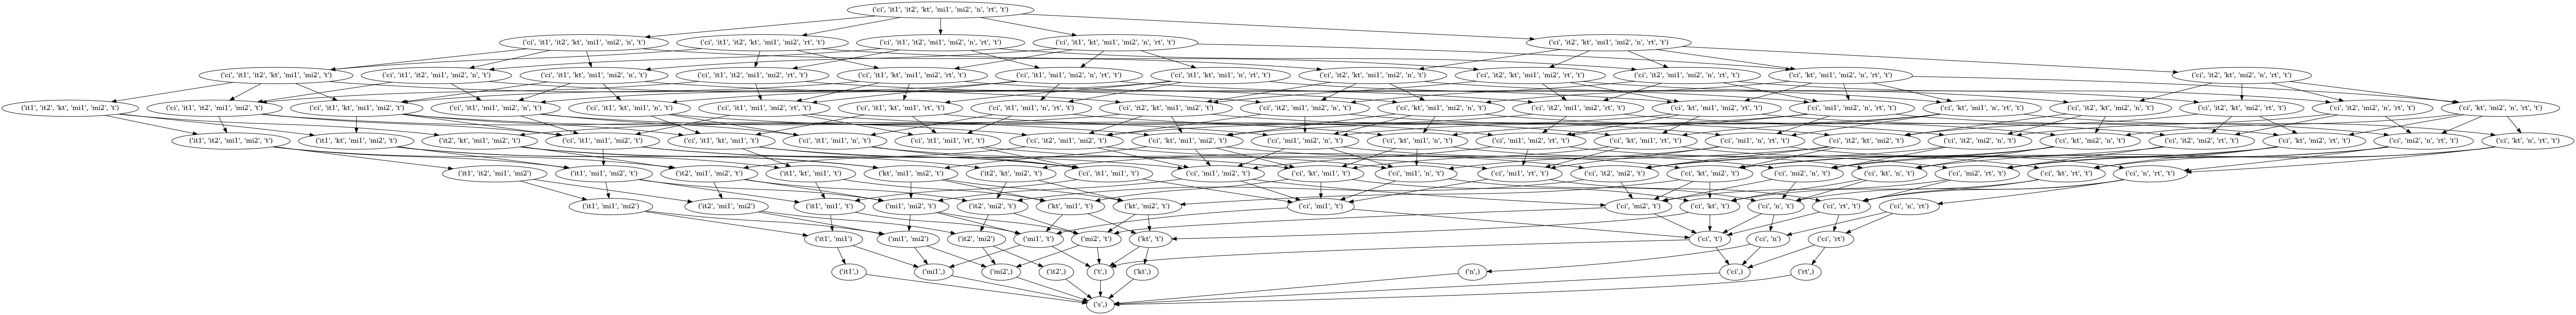

223272514.63399953

In [85]:
subsetg = copy.deepcopy(qrep["subset_graph"])
add_single_node_edges(subsetg)
qrep["subset_graph_paths"] = subsetg
final_node = [n for n,d in subsetg.in_degree() if d==0][0]
source_node = tuple("s")
draw_graph(subsetg)
compute_costs(subsetg, COST_MODEL)

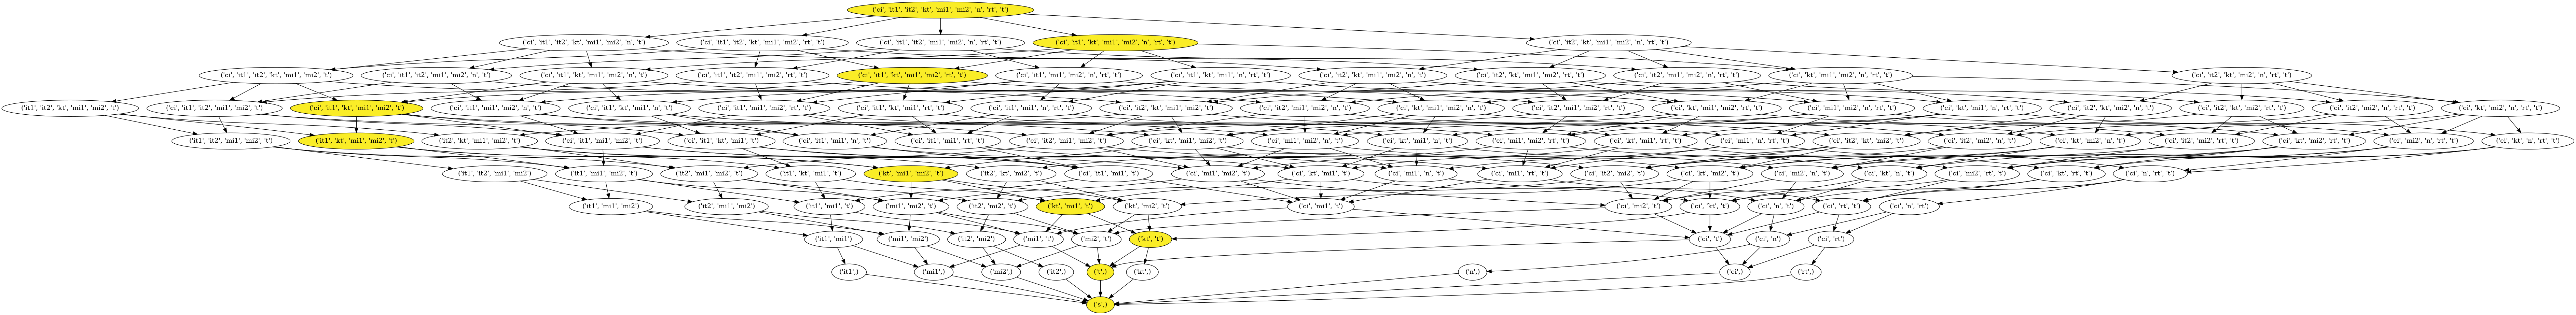

In [86]:
path = nx.shortest_path(subsetg, final_node, source_node, weight=COST_MODEL + "cost")
draw_graph(subsetg, highlight_nodes=path)

In [87]:
path = path[0:-1]
join_order = [tuple(sorted(x)) for x in path_to_join_order(path)]
join_order.reverse()
sql_to_exec = nodes_to_sql(join_order, join_graph)
#print(sql_to_exec)
sql_to_exec = fix_query(sql_to_exec)
#print(sql_to_exec)

print(join_order)
# TODO: figure out a way to cost these

[('t',), ('kt',), ('mi1',), ('mi2',), ('it1',), ('ci',), ('rt',), ('n',), ('it2',)]


In [88]:
cost_sql, est_cost, est_explain = get_join_cost_sql(sql_to_exec, y[0], join_graph, True, "ubuntu", "", "localhost", 5432, "imdb")
jerr = est_cost - opt_cost
print("est_cost: {}, opt_cost: {}, jerr: {}".format(est_cost, opt_cost, jerr))
extract_values(est_explain[0][0], "Node Type")

est_cost: 465185.61, opt_cost: 199621.07, jerr: 265564.54


['Aggregate',
 'Nested Loop',
 'Seq Scan',
 'Nested Loop',
 'Hash Join',
 'Nested Loop',
 'Nested Loop',
 'Seq Scan',
 'Nested Loop',
 'Hash Join',
 'Bitmap Heap Scan',
 'Bitmap Index Scan',
 'Hash',
 'Hash Join',
 'Bitmap Heap Scan',
 'Bitmap Index Scan',
 'Hash',
 'Seq Scan',
 'Index Scan',
 'Index Scan',
 'Hash',
 'Seq Scan',
 'Index Scan']

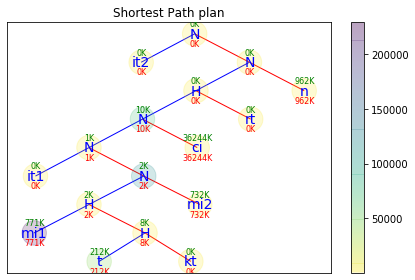

In [89]:
plot_explain_join_order(est_explain, y[0], y[0], None, "Shortest Path plan")
plt.show()

In [91]:
### debug code
use_indexes = True
con = pg.connect(port=PORT,dbname=DB_NAME,
                 user=USER,password=PWD)
cursor = con.cursor()

#cursor.execute("LOAD 'pg_hint_plan';")
#cursor.execute("SET geqo_threshold = {}".format(MAX_JOINS))
#cursor.execute("SET join_collapse_limit = {}".format(MAX_JOINS))
#cursor.execute("SET from_collapse_limit = {}".format(MAX_JOINS))

if not use_indexes:
    set_indexes(cursor, "off")
else:
    set_indexes(cursor, "on")


cursor.execute("SET join_collapse_limit = {}".format(1))
cursor.execute("SET from_collapse_limit = {}".format(1))

sql_order = " explain (format json) " + sql_to_exec
cursor.execute(sql_order)
explain = cursor.fetchall()
est_join_order_sql, est_join_ops, scan_ops = get_pg_join_order(join_graph,
        explain)
leading_hint = get_leading_hint(join_graph, explain)

cursor.execute("LOAD 'pg_hint_plan';")
#cursor.execute("SET geqo_threshold = {}".format(18))
#cursor.execute("SET join_collapse_limit = {}".format(MAX_JOINS))
#cursor.execute("SET from_collapse_limit = {}".format(MAX_JOINS))


est_opt_sql = nx_graph_to_query(join_graph,
        from_clause=est_join_order_sql)
# add the join ops etc. information
cost_sql = get_pghint_modified_sql(est_opt_sql, y[0],
        None, leading_hint, None)

#print(cost_sql)
#cost_sql = "explain (format json)"+ est_opt_sql
#print(cost_sql)

#exec_sql = _get_modified_sql(est_opt_sql, est_cardinalities,
        #None, None, None)

est_cost, est_explain = get_pg_cost_from_sql(cost_sql, cursor)
debug_leading = get_leading_hint(join_graph, est_explain)
print(leading_hint)
print(debug_leading)
print(leading_hint == debug_leading)
cursor.close()
con.close()
print(est_cost)

Leading ((it2 ((((it1 ((mi1 (t kt)) mi2)) ci) rt) n)))
Leading ((it2 ((((it1 ((mi1 (t kt)) mi2)) ci) rt) n)))
True
465185.61


In [589]:
costs = extract_values(est_explain[0][0], "Total Cost")

{('n',): 59865,
 ('ci',): 24090435,
 ('pi1',): 2963664,
 ('it1',): 1,
 ('an',): 901343,
 ('rt',): 4,
 ('ci', 'n'): 341047,
 ('n', 'pi1'): 42515,
 ('an', 'n'): 14341,
 ('ci', 'pi1'): 209646166,
 ('an', 'ci'): 23648388,
 ('ci', 'rt'): 20666853,
 ('it1', 'pi1'): 71202,
 ('an', 'pi1'): 4536141,
 ('ci', 'n', 'pi1'): 3224646,
 ('an', 'ci', 'n'): 426930,
 ('ci', 'n', 'rt'): 283620,
 ('it1', 'n', 'pi1'): 573,
 ('an', 'n', 'pi1'): 72587,
 ('ci', 'it1', 'pi1'): 12945196,
 ('an', 'ci', 'pi1'): 555361826,
 ('ci', 'pi1', 'rt'): 202715027,
 ('an', 'ci', 'rt'): 21419045,
 ('an', 'it1', 'pi1'): 183105,
 ('ci', 'it1', 'n', 'pi1'): 100041,
 ('an', 'ci', 'n', 'pi1'): 14401900,
 ('ci', 'n', 'pi1', 'rt'): 3095905,
 ('an', 'ci', 'n', 'rt'): 385404,
 ('an', 'it1', 'n', 'pi1'): 1530,
 ('an', 'ci', 'it1', 'pi1'): 40143804,
 ('ci', 'it1', 'pi1', 'rt'): 12890822,
 ('an', 'ci', 'pi1', 'rt'): 540757316,
 ('an', 'ci', 'it1', 'n', 'pi1'): 327744,
 ('ci', 'it1', 'n', 'pi1', 'rt'): 99410,
 ('an', 'ci', 'n', 'pi1', 'rt

In [444]:
edges, c, A, b, G, h = construct_lp(subsetg, cost_key=COST_KEY)

In [445]:
print(A.shape)
print("A rank: ", np.linalg.matrix_rank(A))
print(b)
nodes = list(subsetg.nodes())
nodes.sort()

(108, 295)
A rank:  107
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]


In [446]:
start = time.time()
n = len(edges)
x = cp.Variable(n)
constraints = [A @ x == b, G @ x <= 0]
prob = cp.Problem(cp.Minimize(c.T@x), constraints)
prob.solve(verbose=True)
print(prob.value)
print(x.value)
print("linear program took: ", time.time()-start)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.094e+07  +1.094e+07  +1e+08  7e-02  6e-01  1e+00  4e+05    ---    ---    1  1  - |  -  - 
 1  +5.093e+06  +5.409e+06  +9e+07  3e-01  5e-01  3e+05  3e+05  0.9890  8e-01   0  0  0 |  0  0
 2  -9.585e+06  -9.432e+06  +3e+07  3e-01  2e-01  2e+05  1e+05  0.7491  2e-01   0  0  0 |  0  0
 3  -1.274e+07  -1.270e+07  +1e+07  2e-01  5e-02  4e+04  4e+04  0.8051  2e-01   0  0  0 |  0  0
 4  -1.331e+07  -1.329e+07  +6e+06  2e-01  3e-02  1e+04  2e+04  0.9890  5e-01   0  0  0 |  0  0
 5  -1.250e+07  -1.249e+07  +2e+06  1e-01  9e-03  4e+03  7e+03  0.6952  8e-02   0  0  0 |  0  0
 6  -1.197e+07  -1.197e+07  +2e+06  1e-01  6e-03  2e+03  5e+03  0.9890  6e-01   0  0  0 |  0  0
 7  -1.077e+07  -1.077e+07  +6e+05  8e-02  2e-03  7e+02  2e+03  0.9890  3e-01   0  0  0 |  0  0
 8  -9.929e+06  -9.928e+06  +3e+05  7e-02  9e-

going to draw flow path


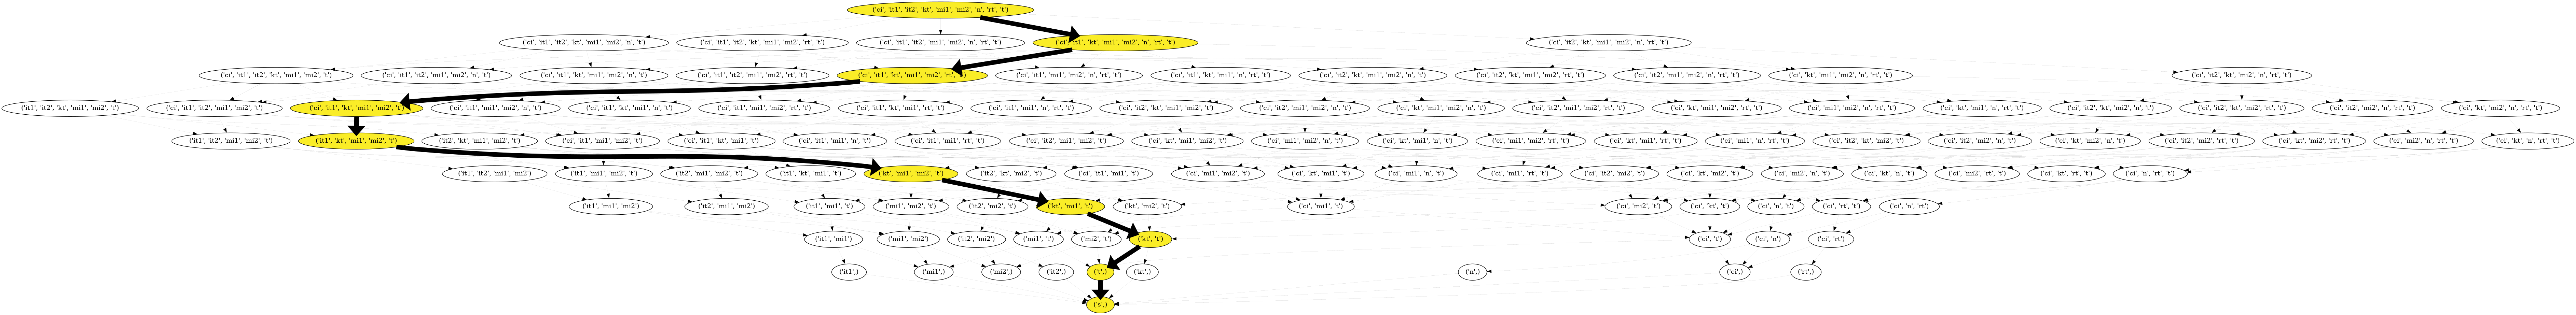

In [447]:
solx = np.array(x.value)
#draw_graph(subsetg, highlight_nodes=best_path_nodes, edge_widths=edge_widths)
plot_flow_path(edges, subsetg, solx, final_node, source_node)

In [457]:
edges, costs, A, b, G, h = construct_lp(subsetg, cost_key=COST_KEY)

n = len(edges)
P = np.zeros((len(edges),len(edges)))
for i,c in enumerate(costs):
    P[i,i] = c
    
q = np.zeros(len(edges))
x = cp.Variable(n)
#prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
#                 [G @ x <= h,
#                  A @ x == b])
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
                 [A @ x == b])
prob.solve(verbose=True)
qsolx = np.array(x.value)
print(qsolx)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 295, constraints m = 108
          nnz(P) + nnz(A) = 885
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   1.32e+04   1.00e-01   4.26e-04s
  50   4.1378e+03   9.34e-09   1.77e-07   1.00e-01   1.54e-03s
plsh   4.1378e+03   6.32e-15   2.36e-12   ---

going to draw flow path


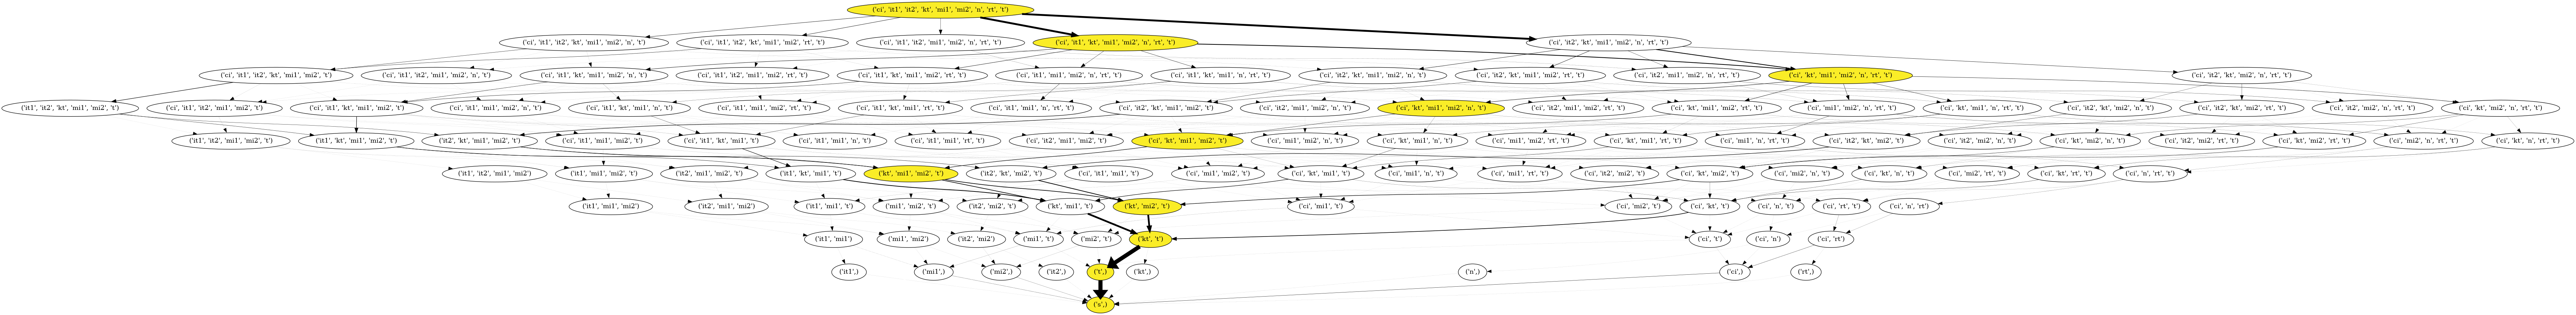

In [458]:
plot_flow_path(edges, subsetg, qsolx, final_node, source_node)

In [459]:
flow_cost, true_costs, Q2, G2, Gv2, v2, invG = debug_flow_loss(qrep, source_node, COST_KEY, COST_MODEL)
flows = Q2 @ v2
print(np.min(flows))
print(np.min(qsolx))

-0.03146528
-0.031465451411041706


In [451]:
print(np.allclose(costs, true_costs))
print(np.allclose(flows, qsolx))

print("actual solution off by a factor of 2")
print(prob.value*2)
print(flow_cost)

True
False
actual solution off by a factor of 2
8283.017887097829
8234.28


going to draw flow path


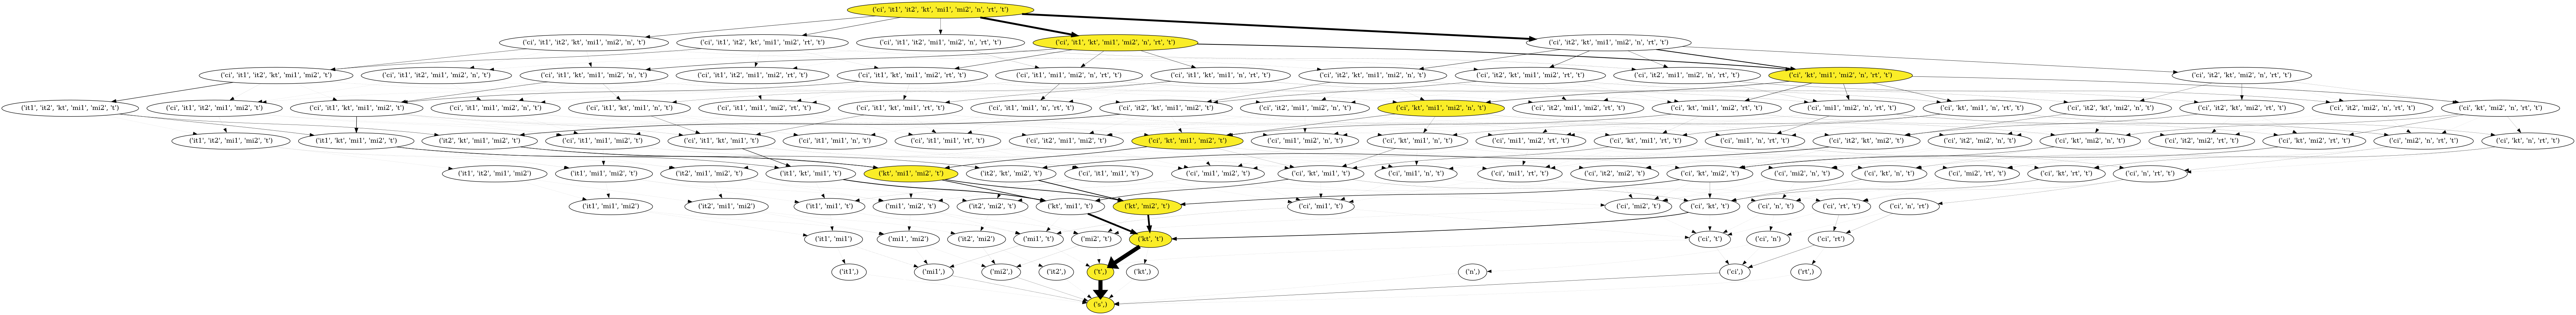

In [452]:
plot_flow_path(edges, subsetg, flows, final_node, source_node)

In [456]:
v2
np.mean(v2)

5827.691